In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

## Initialize Spark session

In [3]:
# Step 1: Initialize Spark session
spark = SparkSession.builder.appName("PageRankAirports").getOrCreate()


23/11/18 15:24:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Load the dataset into DataFrame

In [4]:
# Step 2: Load the dataset into DataFrame
df = spark.read.csv("local/2016.csv", header=True)


## Define Vertices and Edges


In [6]:
# Step 3: Define Vertices and Edges
vertices = df.select("ORIGIN").distinct().withColumnRenamed("ORIGIN", "airport")
edges = df.select("ORIGIN", "DEST").distinct()


In [7]:
vertices.show()

+-------+
|airport|
+-------+
|    BGM|
|    INL|
|    PSE|
|    DLG|
|    MSY|
|    PPG|
|    GEG|
|    SNA|
|    BUR|
|    GRB|
|    GTF|
|    IDA|
|    GRR|
|    JLN|
|    PSG|
|    EUG|
|    GSO|
|    PVD|
|    MYR|
|    OAK|
+-------+
only showing top 20 rows



In [8]:
edges.show()

+------+----+
|ORIGIN|DEST|
+------+----+
|   ORD| PDX|
|   MCI| IAH|
|   ATL| GSP|
|   PHL| MCO|
|   LAS| LIT|
|   SMF| BUR|
|   SNA| PHX|
|   MCI| MKE|
|   MDW| MEM|
|   TPA| ACY|
|   LBB| DEN|
|   SPI| ORD|
|   EWR| STT|
|   PBI| DCA|
|   SJC| LIH|
|   BQN| MCO|
|   CLE| SJU|
|   DSM| EWR|
|   FSD| ATL|
|   ISN| BIL|
+------+----+
only showing top 20 rows



## Spark SQL Setup


In [9]:
# Step 4: Spark SQL Setup
vertices.createOrReplaceTempView("vertices")
edges.createOrReplaceTempView("edges")


## Graph Construction

In [10]:
#Step 5: Graph Construction
graph = spark.sql("""
    SELECT
        e.ORIGIN AS src,
        e.DEST AS dst
    FROM edges e
    JOIN vertices v ON e.ORIGIN = v.airport
""")

In [11]:
graph.show()

+---+---+
|src|dst|
+---+---+
|BGM|DTW|
|DLG|ANC|
|INL|MSP|
|INL|HIB|
|PSE|JFK|
|PSE|MCO|
|MSY|DEN|
|MSY|EWR|
|MSY|DTW|
|MSY|JFK|
|MSY|ATL|
|MSY|LGA|
|MSY|MCI|
|MSY|TPA|
|MSY|ORD|
|MSY|BOS|
|MSY|SAN|
|MSY|BNA|
|MSY|SFO|
|MSY|STL|
+---+---+
only showing top 20 rows



## Graph Visualisation

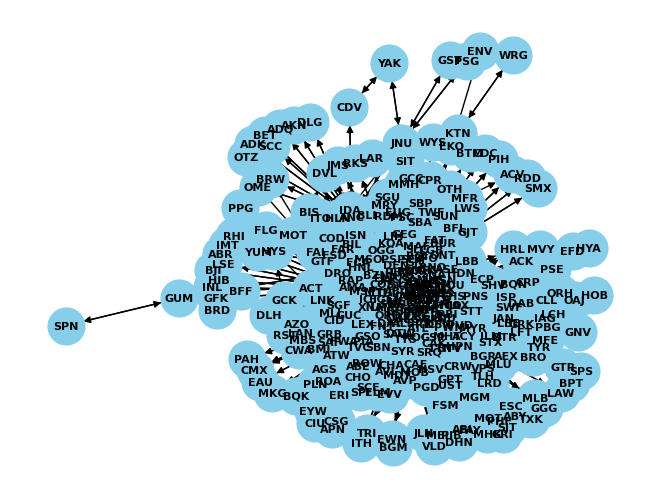

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

# DataFrame containing the graph information
edges = [(row['src'], row['dst']) for row in graph.collect()]

# Create a directed graph using NetworkX
G = nx.DiGraph(edges)

# Plot the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=8, font_color="black", font_weight="bold", arrowsize=10)

# Display the plot
plt.show()


## PageRank Algorithm

In [13]:
from pyspark.sql import Window

In [14]:
# Step 6: PageRank Algorithm
ranks = vertices.withColumn("rank", F.lit(1.0))

In [15]:
for _ in range(10):  # You can adjust the number of iterations
    joined_df = graph.join(ranks, graph.src == ranks.airport, "left").groupBy("dst").agg(F.sum("rank").alias("contribution"))
    window_spec = Window().partitionBy("dst")
    ranks = vertices.join(joined_df, vertices.airport == joined_df.dst, "left") \
        .select("airport", (F.lit(0.15) + F.coalesce(F.sum("contribution").over(window_spec), F.lit(0.0))).alias("rank"))


In [16]:
# Step 7: Identify Most Popular Airports
result = ranks.orderBy(F.desc("rank"))
result.show()


+-------+--------------------+
|airport|                rank|
+-------+--------------------+
|    ATL|9.767026329195758...|
|    ORD|9.345419748239270...|
|    DEN|9.226121646080456E16|
|    DFW|8.572667601720020...|
|    MSP|8.433511183179230...|
|    IAH|8.398609283640872E16|
|    DTW|8.104710227857436...|
|    PHX|7.822236085631100...|
|    LAS|7.761199160408648E16|
|    EWR| 7.73718192445628E16|
|    LAX|7.716455989321307...|
|    CLT|7.233653111794894...|
|    BWI|7.141991149756002...|
|    SEA|7.068317957511152E16|
|    MCO|7.038648574648149...|
|    MDW|7.007685330642548E16|
|    SFO|7.002225937961774...|
|    BOS|6.890232637894252...|
|    SLC|6.791355518784527...|
|    FLL|6.464092936443599...|
+-------+--------------------+
only showing top 20 rows



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame for visualization
result_pd = result.limit(10).toPandas()

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(result_pd['airport'], result_pd['rank'], color='skyblue')
plt.title('Top 10 Airports by PageRank')
plt.xlabel('Airport')
plt.ylabel('PageRank')
plt.xticks(rotation=45, ha='right')
plt.show()


In [19]:
pip install pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 1.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 1.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 2.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
